In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt 

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from bs4 import BeautifulSoup

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)   


**import ไลบรารี่ต่างๆที่จำเป็นที่ต้องใช้ในงานอันได้เเก่**

1.   Pandas ใช้ในการจัดการข้อมูลที่อยู่ในรูปเเบบตาราง(Data Frame)
2.   Seaborn ใช้สำหรับการทำกราฟในรูปเเบบของ 1 sheet ที่มีหลาย chart (Facet)
3.   plotly สำหรับทำกราฟที่สามารถตอบสนองได้ (Inteactive)
4.   matplotlib สำหรับการทำกราฟทั่วไป








### Scraping

In [2]:
main_url = 'https://sgulyano.github.io/eval/'

html_url = ['02226005.html',
            '08846113.html',
            '19689783.html',
            '24363682.html',
            '24674969.html',
            '26742703.html',
            '33472214.html',
            '33561138.html',
            '33565025.html',
            '41557226.html',
            '43951333.html',
            '44868136.html',
            '45435188.html',
            '48033334.html',
            '51435303.html',
            '53231654.html',
            '60189297.html',
            '61116032.html',
            '66887754.html',
            '68346670.html',
            '71728345.html',
            '79550445.html',
            '83255004.html',
            '94026030.html',
            '95860997.html',
            '96905621.html']
eval_url = [main_url + url for url in html_url]

def get_table_data(item):
    data = []
    table_body = item.find("tbody")
    rows = table_body.find_all("tr")
    for row in rows :
        cols = row.find_all(["td","th"])
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    return data
    
dfs = []

for j in range(26):
    page  = j
    r = requests.get(eval_url[page])
    soup = BeautifulSoup(r.content,"html.parser")
    tables = soup.find_all("table")
    head = pd.DataFrame(get_table_data(tables[0]))
    section = head.iloc[1,1]

# Adjust dataframe
    df = pd.DataFrame(get_table_data(tables[2]))
    df.dropna(how="all",inplace=True)
    df.columns = df.iloc[1,:]
    rows = [0,1]
    df.drop(rows,axis=0,inplace=True)
    df.drop(df[df.ที่.str.contains("รวม")].index , inplace= True)


    df["topic"] = ""
    ind = 0
    for i in df["ที่"]:
        if len(i) > 1:
            topic = i
            df.iloc[ind,16] = topic
            ind += 1
        else:
            df.iloc[ind,16] = topic
            ind +=1 
    df.dropna(inplace= True)


# change all column "ร้อยละ" name
    cols = []
    count = 5
    for column in df.columns:
        if column == 'ร้อยละ':
            cols.append(f'{count}(%)')
            count-=1
            continue
        cols.append(column)
    df.columns = cols

    for i in range(2,15):
        df.iloc[:,i] = pd.to_numeric(df.iloc[:,i])
    df.set_index("ที่" , inplace= True)
# add  detail to data frame

    df["degree"] = head.iloc[3,1]
    df["semester"] = head.iloc[2,1]  
    df["subject"] = head.iloc[0,1]
    df["section"] = head.iloc[1,1]
    df["นักศึกษาที่จดทะเบียน"] = head.iloc[4,1]
    df["นักศึกษาที่ประเมิน"] = head.iloc[5,1]
    df["url"] = eval_url[page]

    dfs.append(df)
    
# concat all websites
result = pd.concat([dfs[i] for i in range(26)])

# separate year & semester 
result["year"] = ""
result["sem"] = ""

count = 0
for i in result["semester"]:
    yr_splt = i.split("/")
    result["year"][count] = yr_splt[1]
    result["sem"][count] = yr_splt[0]
    count += 1


result["n"] = ""
for i in range(len(result["นักศึกษาที่ประเมิน"])):
    result["n"][i] = result["นักศึกษาที่ประเมิน"][i].split(" ")[0]
result["n"] = pd.to_numeric(result["n"])

result["class"] = result["semester"] + "|" + result["subject"] + "|" + result["section"]

covid = result[result["ข้อคำถาม"].str.contains("COVID-19")]
covid["situation"] = "covid"
covid = covid.filter(['class', 'situation'])
covid.drop_duplicates(inplace= True)

df = pd.merge(result,covid,on="class" , how="outer")
df["situation"].fillna("normal" , inplace=True)
df.rename(columns={"X-Bar" : "x_bar"},inplace= True)
df.drop(columns= ["url","class", "นักศึกษาที่ประเมิน"],inplace= True)
df['0-1(%)'] = df['0(%)'] + df['1(%)'] 


1.   เรียกใช้คำสั่ง drop จาก Library pandas เพื่อลบ Missing Dataจาก column ที่ชื่อ url class และ นักศึกษาที่ประเมิน เเละใช้คำสั่ง inplace=true เพื่อเป็นการ Update ตารางใหม่โดยถาวร



1. สร้าง column ใหม่ที่เป็นการ merge column 0% กับ 1%

# ส่วนใหม่

In [3]:
degree_compare = df.pivot_table(index=['degree','year','sem','subject'] , values='section',aggfunc= pd.Series.nunique).reset_index()
fig = px.bar(degree_compare.pivot_table(index=['degree','year'], values='section' , aggfunc='sum').reset_index(), x='year' , y='section' , facet_col='degree' , text_auto=True )

fig.update_layout({
'plot_bgcolor':'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_xaxes(gridcolor='rgba(0, 0, 0, 0)' , linecolor = 'black' ,linewidth = 1.5 )
fig.update_yaxes(gridcolor='rgba(0, 0, 0, 0)' , linecolor = 'black'  , linewidth = 1.5)
fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5 ,
                  )
fig.show()

1.กำหนดตัวแปร degree_compare เพื่อสร้าง pivot_table ที่อิงข้อมูลจากตารางใน df โดยกำหนด dimension values คือ degree, year, sem, subject เเละ measurement value คือ section กำหนดฟังก์ชั่นที่ทำ interactive ในกราฟคือ nunique เเละให้ reset index ที่เกิดเมื่อเจอ nunique value
2. ใช้ libary plotly.express เพื่อสร้างกราฟแท่ง โดยอ้างอิงฟังก์ชั่นจากตัวแปร degree_compare โดยกำหนดแกน x เป็น year แกน y เป็น section ใช้ color ในการเเยกเเต่ละ degree เเละกำหนด facet ให้เเสดงผลได้หลายกราฟโดยเเบ่งตาม degree

**สาเหตุ**
* เพื่อต้องการแสดงให้เห็นว่ามีเพียงข้อมูล ปริญญาตรีโครงการพิเศษ เท่านั้นที่มีข้อมูลครบทั้ง 4 ปี

In [4]:
df = df.query("degree == 'ปริญญาตรี โครงการพิเศษ' ")

1. กำหนดตัวแปร df เพื่อเก็บข้อมูล degree ที่เป็น ปริญญาตรี โครงการพิเศษ 

In [5]:
pvt = df.pivot_table(index=["year","sem","situation","subject"] ,values= ["section"] , aggfunc= pd.Series.nunique).reset_index()

fig = make_subplots(rows=1, cols=4 ,specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
for i in range(1,5):
  fig.add_trace(go.Pie(labels=pvt.loc[pvt["year"] == f'256{i}' , 'situation'], values=pvt.loc[pvt["year"] == f'256{i}' , 'section'], name=f"256{i}"),1, i)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Situation 2561 - 2564",
    # Add annotations in the center of the donut pies.
      annotations=[dict(text='2561', x=0.093 , y=0.5, font_size=20, showarrow=False),
                  dict(text='2562', x=0.368 , y=0.5, font_size=20, showarrow=False),
                  dict(text='2563', x=0.633, y=0.5, font_size=20, showarrow=False),
                  dict(text='2564', x=0.906, y=0.5, font_size=20, showarrow=False)
                  ])
fig.show()



1.   กำหนดตัวแปร pvt เพื่อสร้าง pivot_table ที่อิงข้อมูลจากตารางใน df โดยกำหนด 
dimension values คือ year, sem, situaton, subject เเละ measurement value คือ section โดยจะนับ section ในแต่ละวิชา และ reset index เพื่อเปลี่ยนจากตาราง pivot เป็นตารางปกติ เพื่อนำไปทำกราฟต่อ
2.   กำหนดตัวแปร fig และใช้คำสั่ง make_subplots เพื่อสร้าง หลายกราฟใน 1 รูป โดยกำหนดเป็น 1 แถว 4 คอลัมน์ เเละใช้คำสั่ง for loop และเรียกใช้ฟังก์ชั่น add_trace เพื่อสร้าง pie chart 4 รูป
3. เปลี่ยน pie chart ให้เป็น donut chart โดยเพิ่มรูเข้าไปตรงกลาง
4. เรียกใช้ฟังก์ชั่น update_layout โดยใช้กำหนดชื่อกราฟ,กำหนดข้อความ,ตั้งค่าตำแหน่ง x และ y ,และขนาดฟ้อนต์ใน donut chart


**สาเหตุ**
* ต้องการแสดงให้เห็นสัดส่วนระหว่างสถานการณ์ธรรมดา / โควิด ในแต่ละปี
* เนื่องจากชุดคำถามของแต่ละสถานการณ์แตกต่างกัน

**แยก situation**

In [6]:
cov = df.query("situation == 'covid'")
norm = df.query("situation == 'normal'")

1. สร้างตัวแปร cov เพื่อเก็บข้อมูลที่เป็น situation covid
2. สร้างตัวแปร norm เพื่อเก็บข้อมูลที่เป็น situation normal


**Add pie chart "Topic" each degree/situation**

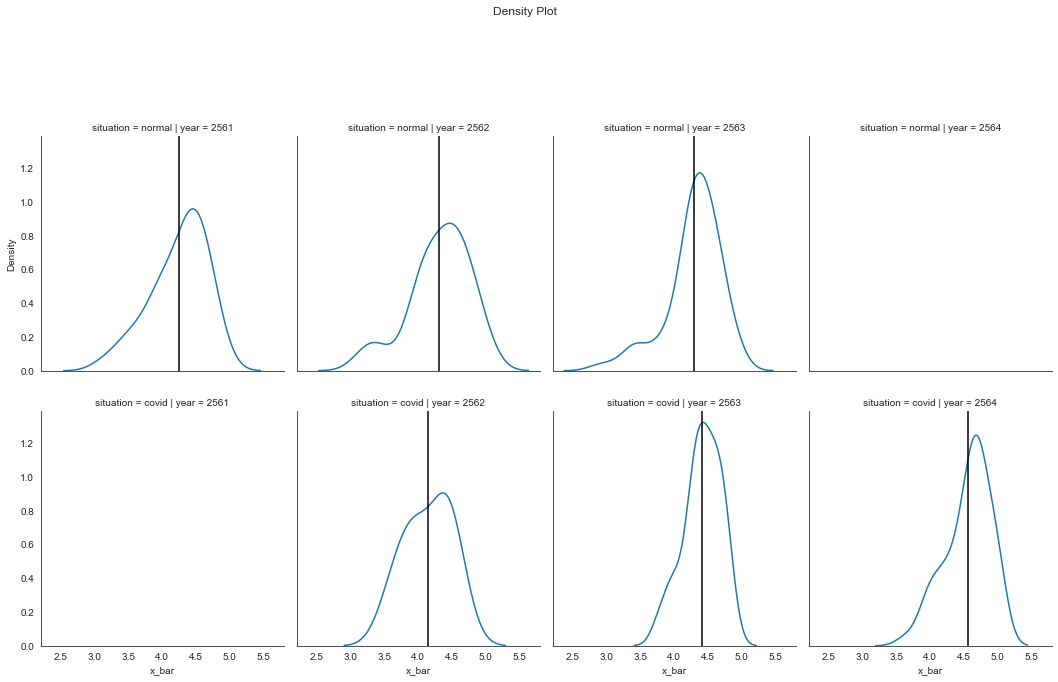

In [7]:
sns.set_style("white")

g = sns.FacetGrid(df , col="year" ,row='situation' , col_order=sorted(df['year'].unique()) )
g = g.map(sns.kdeplot , "x_bar")
g = g.map(lambda y, **kw: plt.axvline(y.mean(), color="k"), 'x_bar')

g.fig.set_size_inches(15,10)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Density Plot")
sns.despine()

1.  ใช้ libary seaborn
2.  กำหนดตัวแปร g ใช้ฟังก์ชั่น FacetGrid เพื่อแบ่งกราฟเป็น 8 กราฟ โดยคอลัมน์แบ่งตามปี และ แถวแบ่งตามสถานการณ์
3. ใช้ฟังก์ชั่น map เพื่อกำหนดภาพรวมของกราฟ โดยกำหนดให้แกน x เป็น x_bar และ รูปแบบเป็น density plot
4. ใช้ฟังก์ชั่น refline เพื่อสร้างเส้นอ้างอิงโดยกำหนดค่าอิงคือค่าเฉลี่ยต่อปี และ สถานการณ์ 
5. เรียกใช้ตัวแปร fig แล้วใช้ฟังก์ชั่น subplots_adjust เพื่อเลื่อนtitleให้สูงขึ้น และใช้ฟังก์ชั่น suptitle เพื่อตั้งชื่อ(title)ให้กราฟ


C:\Users\User\AppData\Local\Temp\ipykernel_12632\3749186320.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



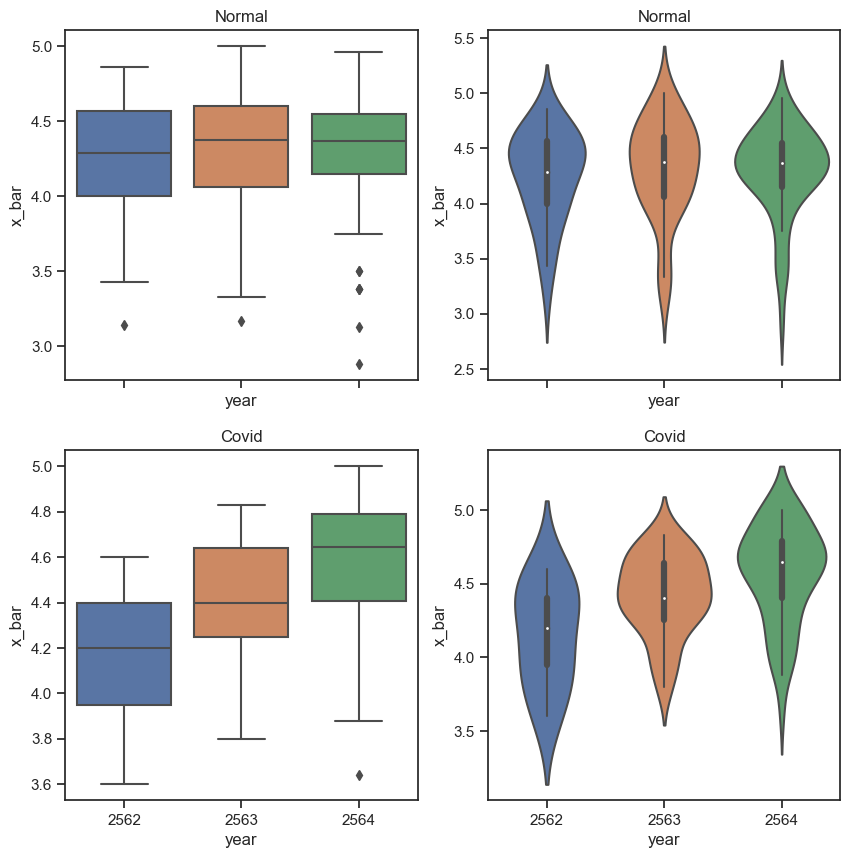

In [8]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 2 ,sharex=True, figsize=(10,10))

sns.boxplot(ax=axes[0,0], data=norm.sort_values(by='year') , x='year', y='x_bar')
axes[0,0].set_title('Normal')

sns.violinplot(ax=axes[0,1] , data=norm.sort_values(by='year') , x='year', y='x_bar')
axes[0,1].set_title('Normal')

sns.boxplot(ax=axes[1,0] , data=cov.sort_values(by='year') , x='year', y='x_bar')
axes[1,0].set_title('Covid')

sns.violinplot(ax=axes[1,1] , data=cov.sort_values(by='year') , x='year', y='x_bar')
axes[1,1].set_title('Covid')

fig.show()



1. ใช้ libary seaborn
2. สร้าง subplot ให้มี 2 แถว 2 คอลัมน์ และกำหนดขนาด
3. สร้าง boxplot ในแถวที่ 1 คอลัมน์ที่ 1 โดยอิงข้อมูลจาก norm ที่เรียงตามปี กำหนดแกน x เป็นปี แกน y เป็น x_bar และกำหนดชื่อเป็น Normal ซึ่งก็คือแสดงถึงภาวะปกติ
4. สร้าง violin plot ในแถวที่ 1 คอลัมน์ที 2 โดยอิงข้อมูลจาก norm ที่เรียงตามปี กำหนดแกน x เป็นปี แกน y เป็น x_bar และกำหนดชื่อเป็น Normal ซึ่งก็คือแสดงถึงภาวะปกติ
5. สร้าง boxplot ในแถวที่ 2 คอลัมน์ที่ 1 โดยอิงข้อมูลจาก cov ที่เรียงตามปี กำหนดแกน x เป็นปี แกน y เป็น x_bar และกำหนดชื่อเป็น Covid ซึ่งก็คือแสดงถึงภาวะโควิด
6. สร้าง violin plot ในแถวที่ 2 คอลัมน์ที 2 โดยอิงข้อมูลจาก cov ที่เรียงตามปี กำหนดแกน x เป็นปี แกน y เป็น x_bar และกำหนดชื่อเป็น Covid ซึ่งก็คือแสดงถึงภาวะโควิด


In [9]:
outliners = []
for sit in [cov,norm]:
    for year in sorted(sit['year'].unique()): 
        q3 = sit.loc[(sit['year'] == year) , 'x_bar'].quantile(0.75) 
        q1 = sit.loc[(sit['year'] == year) , 'x_bar'].quantile(0.25)
        iqr = q3 - q1
        outline = sit[(sit['year'] == year)&((sit['x_bar'] > q3 + (1.5 * iqr)) | (sit['x_bar'] < q1 - (1.5 *iqr))) ]
        outliners.append(outline)
outliner  = pd.concat(outliners)
outliner.pivot_table(index=['situation','year', 'subject','topic','ข้อคำถาม'], values='x_bar' )

x_bar
situation year subject topic                                           ข้อคำถาม                                                 
covid     2564 YRY790  ส่วนที่ 1 ข้อคำถามกลางของมหาวิทยาลัย            ผู้สอนอธิบายชัดเจน ตรงประเด็น มีการยกตัวอย่างปร...   3.64
normal    2561 YRY790  ส่วนที่ 1 ข้อคำถามกลางของมหาวิทยาลัย            กระตุ้นบรรยากาศการเรียนการสอน มีวิธีสอนที่น่าสน...   3.14
          2562 FGL497  ส่วนที่ 3 สภาพแวดล้อมและสิ่งสนับสนุนการเรียนรู้ สภาพของห้องเรียนหรือห้องปฏิบัติการ เช่น แสง อุณ...   3.17
          2563 YRY790  ส่วนที่ 1 ข้อคำถามกลางของมหาวิทยาลัย            กระตุ้นบรรยากาศการเรียนการสอน มีวิธีสอนที่น่าสน...   3.13
                                                                       ทำให้เห็นความสัมพันธ์กับวิชาอื่นที่เกี่ยวข้อง        3.38
                                                                       สอนให้คิด วิเคราะห์ วิจารณ์                          3.38
                                                                       แนะนำแหล่งค้นคว้าข้อมูลเพิ่มเติมให้                  2.88
                                                                       ใช้สื่อและอุปกรณ์ช่วยสอนได้ดี                        3.50
                       ส่วนที่ 2 ข้อคำถามของคณะ/หน่วยงาน               ผู้สอนชี้แนะจุดมุ่งหมายประเด็นหรือข้อสรุปที่เป็...   3.38
                                                                       ผู้สอนแทรกเนื้อหาเกี่ยวกับคุณธรรมจริยธรรมในการเ...   3.50



1. สร้างตัวแปร subplot ให้มี 1 แถว 2 คอลัมน์
2. plot แผนภาพกล่องลงไปโดยแบ่งตามสถานการณ์ และ ใช้แกน x เป็นปี
3. หาค่า x-bar ที่มากกว่า หรือ น้อยกว่า1.5เท่าของพิสัยระหว่างควอไทล์  ในแต่ละสถานการณ์ ในแต่ละปี และนำมารวมกัน
4. สร้าง pivot table เพื่อแสดงข้อมูลเกี่ยวกับ ค่านอกเกณฑ์ที่เจอ


**สาเหตุ**
* เพื่อดูว่ารายวิชาไหนคะแนนเฉลี่ยเป็นค่านอกเกณฑ์จากรายวิชาอื่นๆในแต่ละปี/สถานการณ์
* เพื่อหา และ แสดงสาเหตุของค่านอกเกณฑ์นั้นๆ 

In [10]:
def pvt(data , year) :   
    pvt = data.pivot_table(index = ['year' , 'sem', "subject" ] , values= 'x_bar' , aggfunc= 'mean').reset_index()
    pvt.loc[pvt['year'] == year ,'diff']  =  pvt.loc[pvt['year'] == year ,'x_bar']  - pvt.loc[pvt['year'] == year ,'x_bar'].mean() 
    pvt['color'] = ""
    ind = 0
    for i in pvt['diff']  :
        if i > 0 :
            pvt.iloc[ind , 5] = 'green'
            ind += 1
        else: 
            pvt.iloc[ind , 5] = 'red'
            ind+=1
    pvt["dec"] = pvt['diff'].round(3)
    pvt["mean"] = pvt.loc[pvt['year'] == year ,'x_bar'].mean() 
    return pvt[pvt['year'] == year]

1. สร้างฟังก์ชั่น pvt โดยรับพารามิเตอร์จาก data และ year
2. กำหนดตัวแปร pvt เพื่อสร้าง pivot_table ที่อิงข้อมูลจากตารางใน data โดยกำหนด dimension values คือ year, sem, subject  measurement value คือ x_bar แล้วหาค่าเฉลี่ย
3.หาผลต่างระหว่างค่าเฉลี่ยของปีนั้นกับค่าเฉลี่ยของแต่ละวิชาแล้วเก็บไว้ในตัวแปร diff 
4. สร้าง coloum color ที่เป็น Nan และ กำหนดตัวแปร ind = 0
5. สร้าง for loop ในการ loop แต่ละครั้งถ้าค่า diff มากว่าก 0 จะให้ column color = green แต่ถ้าน้อยกว่า 0 จะให้ coloum color = red และในการ loop แต่ละครั้ง ind จะเพิ่มทีละ 1 เรื่อยๆ เพื่อเปลี่ยนทีละ row
6. ใช้ฟังก์ชั่น round ปัดทศนิยมให้เหลือ 3 ตำแหน่ง



In [11]:
fig = make_subplots(rows=2, cols=4 , subplot_titles= ['Mean : 4.246','Mean : 4.316' , 'Mean : 4.223','','','','Mean : 4.431', 'Mean : 4.563'] )

for i in range(1,5):
    fig.add_trace(
        go.Bar(x=pvt(cov,f'256{i}')['subject'], y= pvt(cov,f'256{i}')['diff'] , marker=  dict(color =pvt(cov,f'256{i}')['color']) , text= pvt(cov,f'256{i}')['dec']  ),
        row=2, col=i
)

for i in range(1,5):
    fig.add_trace(
        go.Bar(x=pvt(norm,f'256{i}')['subject'], y=pvt(norm,f'256{i}')['diff'] , marker=  dict(color = pvt(norm,f'256{i}')['color']), text= pvt(norm,f'256{i}')['dec']),
        row=1, col=i
    )

for i in range(1,5):
    fig.update_xaxes(title_text= f"256{i}", row=2, col=i)

fig.update_yaxes(title_text= "Normal", row=1, col=1)
fig.update_yaxes(title_text= "Covid"  ,  row=2, col=1  )
fig.update_layout(showlegend=False, height=1000, width=2000 ,title_text="Difference From Mean" , font = dict(size = 18))
fig.update_traces(textposition='auto')
fig.show()




1. กำหนดตัวแปร fig สร้าง subplot โดยมี 2 แถว 4 คอลัมน์ และกำหนดชื่อของแต่ละกราฟ
2. สร้าง for loop เพื่อสร้างกราฟแท่งแถวที่ 2 จำนวน 4 กราฟ อิงข้อมูลจาก situation covid โดยในการ loop แต่ละครั้งแกน x จะเป็นวิชาในปีนั้น แกน y จะเป็นผลต่างระหว่างค่าเฉลี่ยของปีนั้นกับค่าเฉลี่ยของวิชาในปีนั้น สีของกราฟแท่งจะขึ้นอยู่กับ coloum color และค่าของ diff จะมีทศนิยม 3 ตำแหน่งตามที่กำหนดไว้ใน dec
3. สร้าง for loop เพื่อสร้างกราฟแท่งแถวที่ 1 จำนวน 4 กราฟ อิงข้อมูลจาก situation normal ในการ loop แต่ละครั้งแกน x จะเป็นวิชาในปีนั้น แกน y จะเป็นผลต่างระหว่างค่าเฉลี่ยของปีนั้นกับค่าเฉลี่ยของวิชาในปีนั้น โดยสีของกราฟแท่งจะขึ้นอยู่กับ coloum color และค่าของ diff จะมีทศนิยม 3 ตำแหน่งตามที่กำหนดไว้ใน dec
4. สร้าง for loop เพื่อกำหนดชื่อกราฟแต่ละ coloum เป็นปีแต่ละปี
5. กำหนดชื่อในแนวแกน y แถวที่ 1 เป็น normal แถวที่ 2 เป็น covid
6. กำหนดความสูงและความกว้างของกราฟทุกอัน และกำหนดชื่อกับขนาดฟ้อนต์ของชื่อ subplot

**สาเหตุ**
* เพื่อแสดงความแตกต่างระหว่าง คะแนนเฉลี่ยต่อปี และ สถานการณ์ กับ คะแนนเฉลี่ยของแต่ละวิชา

In [12]:

fig = px.treemap(outliner , path=[ 'degree' ,'situation','year','subject','section' , 'topic' , 'ข้อคำถาม' ] , values='x_bar' ,  color='x_bar', hover_data=['x_bar'],
                  color_continuous_scale= 'ice',
                  color_continuous_midpoint=np.average(outliner['x_bar']) ,
                  width=2000, height=1000)


fig.update_layout(margin = dict(t=5, l=5, r=5, b=5))
fig.update_layout({
'plot_bgcolor':'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.update_traces(textinfo = 'label')
fig.update_layout(uniformtext=dict(minsize=14, mode='show'))
fig.show()

1.   กำหนดตัวแปร fig เพื่อสร้าง tree map โดยอิงข้อมูลจาก outliner กำหนด dimension layer เป็น degree, situation, year, subject , section , topic , ข้อคำถาม measurement value คือ x_bar แล้วสี layout ละเปลี่ยนตามค่าx_bar กำหนดgradiantเป็นรูปแบบ 'ice'
2. กำหนดขนาดของกราฟ
3. ใช้ฟังก์ชั่น update_layout เพื่อกำหนดตำแหน่
ของกราฟ และทำbackgroundเป็นpng
4. ใช้ฟังก์ชั่น update_traces เพื่อใส่ label ลงในแต่ละ layout
5. กำหนดขนาดตัวอักษร

**สาเหตุ**
1. ต้องการดูว่าใน outliner ทั้งหมด มีสัดส่วนวิชา/คำถาม เป็นอย่างไร
2. สีที่เข้มขึ้นหมายถึง x bar ที่น้อยลง ซึ่งบ่งบอกถึง outliner ที่ไกลขึ้น

In [14]:
from scipy import stats

In [16]:
df.sort

,5,5(%),4,4(%),3,3(%),2,2(%),1,1(%),...,degree,semester,subject,section,นักศึกษาที่จดทะเบียน,year,sem,n,situation,0-1(%)
ข้อคำถาม,,,,,,,,,,,,,,,,,,,,,
สอนอย่างเป็นระบบ,4,66.67,1,16.67,0,0.00,1,16.67,0,0.00,...,ปริญญาตรี โครงการพิเศษ,1/2562,FGL497,231863,43,2562,1,6,normal,0.00
สอนให้คิด วิเคราะห์ วิจารณ์,4,66.67,0,0.00,1,16.67,1,16.67,0,0.00,...,ปริญญาตรี โครงการพิเศษ,1/2562,FGL497,231863,43,2562,1,6,normal,0.00
กระตุ้นบรรยากาศการเรียนการสอน มีวิธีสอนที่น่าสนใจและน่าติดตาม,2,33.33,1,16.67,1,16.67,1,16.67,1,16.67,...,ปริญญาตรี โครงการพิเศษ,1/2562,FGL497,231863,43,2562,1,6,normal,16.67
เปิดโอกาสให้แสดงความคิดเห็นและแลกเปลี่ยนประสบการณ์ ทั้งภายในและภายนอกห้องเรียน,3,50.00,2,33.33,0,0.00,0,0.00,1,16.67,...,ปริญญาตรี โครงการพิเศษ,1/2562,FGL497,231863,43,2562,1,6,normal,16.67
มีการให้นำเสนองาน/มีการวัดผลโดยวิธีอื่นๆที่สะท้อนความสามารถของผู้เรียนนอกเหนือจากการตอบข้อสอบ,3,50.00,2,33.33,1,16.67,0,0.00,0,0.00,...,ปริญญาตรี โครงการพิเศษ,1/2562,FGL497,231863,43,2562,1,6,normal,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ผู้สอนแทรกเนื้อหาเกี่ยวกับคุณธรรมจริยธรรมในการเรียนการสอน,15,51.72,9,31.03,3,10.34,2,6.90,0,0.00,...,ปริญญาตรี โครงการพิเศษ,1/2563,NYE553,231863,43,2563,1,29,normal,0.00
โสตทัศนูปกรณ์ช่วยสอนในห้องเรียน เช่น ไมโครโฟน เครื่องฉายแผ่นทึบ มีคุณภาพพร้อมใช้งาน,14,48.28,8,27.59,5,17.24,1,3.45,1,3.45,...,ปริญญาตรี โครงการพิเศษ,1/2563,NYE553,231863,43,2563,1,29,normal,3.45
สภาพของห้องเรียนหรือห้องปฏิบัติการ เช่น แสง อุณหภูมิ โต๊ะ เก้าอี้ จุดเชื่อมต่ออินเตอร์เน็ตไร้สายบริการ ฯลฯ มีความเหมาะสมและคุณภาพพร้อมใช้งาน,13,44.83,11,37.93,4,13.79,0,0.00,1,3.45,...,ปริญญาตรี โครงการพิเศษ,1/2563,NYE553,231863,43,2563,1,29,normal,3.45


In [17]:
4 % 7 + 6

10

In [18]:
[
i.upper()
 
for i
 ['hello', 'world']]

'mercury'

In [20]:
[i.upper() for i in ['hello', 'world']]

['HELLO', 'WORLD']

In [33]:
def factorial(n):
    """returns n!"""
    return 1 if n < 2 else n * factorial(n-1)

factorial.__doc__

'returns n!'

In [34]:
a = {1, 2, 3, 4}
b = {3, 4, 5, 6}

In [35]:
a.intersection(b)

{3, 4}

In [36]:
x = lambda : "I know how to call this function."

In [40]:
x()

'I know how to call this function.'